<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Эмбеддинги" data-toc-modified-id="Эмбеддинги-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Эмбеддинги</a></span><ul class="toc-item"><li><span><a href="#Получим-эмбеддинги" data-toc-modified-id="Получим-эмбеддинги-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Получим эмбеддинги</a></span></li><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Первичный анализ</a></span></li></ul></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline</a></span><ul class="toc-item"><li><span><a href="#Подготовим-данные" data-toc-modified-id="Подготовим-данные-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовим данные</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Сatboost" data-toc-modified-id="Сatboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Сatboost</a></span></li></ul></li><li><span><a href="#Fast-AI" data-toc-modified-id="Fast-AI-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fast AI</a></span></li><li><span><a href="#Проверим-работу-модели" data-toc-modified-id="Проверим-работу-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверим работу модели</a></span></li></ul></div>

# Разработка модель определения ориентации текста справки для DonorSearch и автоматического поворота.

__Цель:__

Заказчик - DonorSearch -  занимается развитием донорства в стране. Разработать модель определения ориентации справки и автоматического поворота ее в нормальное положение перед запуском сервиса OCR. Нормальное положение - это вертикальная ориентация справки.

__Данные:__

Нам предоставлено 173 справки различной ориентации.

__Метрика:__

Метрики для классификации: Accuracy, Precision, Recall, F1.

__План работ:__

1) Увеличить количество справок для обучения модели в 4 раза с помощью поворота каждой справки в 4 положения:
 - 0, 90, 180 и 270 градусов.

2) Изучить данные, посмотреть на изображения српавок.

3) Извлечь эмбеддинги и построить baseline модель. Будем классифицировать справки по 4 классам:
- 0 - справки повренутые на 0 градусов,
- 1 - справки повернутые на 90 градусов,
- 2 - справки повернутые на 180 градусов,
- 3 - справки повернутые на 270 градусов.

В качестве baseline возьмем модель LogisticRegression. Изучить  метрику.  

4) Построить модель определения ориентации справки с помощью сверточной нейросети. За основу возьмем предобученую модель ResNet50. Изучить метрику.

5) Применить модель для классификации тестового изображения. И применить автоматический поворот в 0 градусов.

In [ ]:
## проверим какая среда подключина
!nvidia-smi

Tue Oct  1 11:06:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# установим fastai и optuna
!pip install fastai -q
!pip install optuna -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [4]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import optuna

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from fastai.vision.all import *
from optuna.samplers import TPESampler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter('ignore')

In [5]:
## подключим гугул диск
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
## проверяем работу диска
!pwd

/content


In [6]:
## смотрим на путь к файлам
!ls /content/drive/MyDrive/donor_search/data

0  1  2  3


In [8]:
# константы
SEED = 42                                              # случайные числа
BATCH_SIZE = 32                                        # размер батча
IMG_SIDE_RESIZE = 224                                  # длина стороны изображения для ресайза
IMG_SIDE_CROP = 224                                    # длина стороны изображения для кропа
NORMALIZE_MEAN = [0.485, 0.456, 0.406]                 # mean values для нормализации изображений
NORMALIZE_STD = [0.229, 0.224, 0.225]                  # std values для нормализации изображений
PATH_IMAGES = '/content/drive/MyDrive/donor_search/data'            # путь к основной папке с изображениями
EMB = '/content/drive/MyDrive/donor_search/emb_data.csv'        # путь к эмбеддингам
INPUT_IMAGE_PATH = '/content/drive/MyDrive/donor_search/test_image/IMG_3599.png'       # тестовые изображения
OUTPUT_IMAGE_PATH = '/content/drive/MyDrive/donor_search/pred_image/IMG_3599_pred.png' # изобрадения на выходе
MY_RESNET50 = '/content/drive/MyDrive/donor_search/my_resnet50_export.pkl'             # обученая модель

## Первичный анализ данных

In [15]:
# создадим датафрейм с классами и названиями изображений
df = pd.DataFrame(columns=['target', 'image'])

for root, dirs, files in os.walk(PATH_IMAGES):  # возвращает путь к каталогу, список имен подкаталогов и имен файлов
    target = root.split('/')[-1]
    data = [{'target': target, 'image': os.path.join(target, file)} for file in files if file.endswith('.png')]
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

In [16]:
print('Размер датафрейма', df.shape)

Размер датафрейма (692, 2)


In [17]:
display(df.sample(3)) # проверим как выглядит датафрейм

,target,image
645,2,2/444___eaa2a07003b544199341c2c71594459b.png
459,3,3/444___d9053d46be084df4a8679d7b7f3b4730.png
161,1,1/448___3ce9fe648f6b4ab7afd39c9f8d28f8dd.png


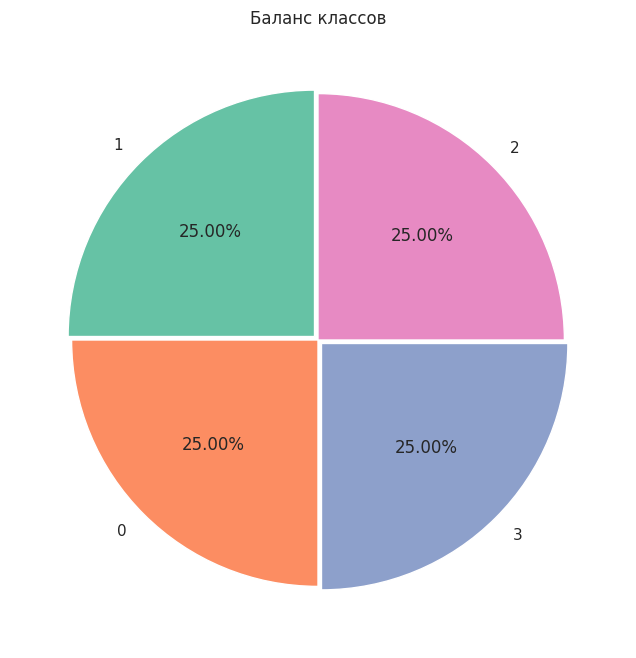

In [18]:
# граффик баланса классов
target_counts = df['target'].value_counts()
labels = target_counts.index
sns.set(font_scale = 1)
plt.figure(figsize=(8,8))

plt.pie(
    x = target_counts,
    labels = target_counts.index,
    autopct = '%1.2f%%',
    colors = sns.color_palette('Set2'),
    startangle = 90,
    explode = [0.02, 0, 0.02, 0]
)
plt.title('Баланс класcов')
plt.show()

<div class="alert alert-success">
<b>отлично что на дисбаланс посмотрели ✅:</b> </div>
    



In [ ]:
def show_images(path_image, data, number):

    '''
    Функция для просмотра изображений.
    На вход получает путь к папке с изображениями, датафрейм, количиство изображений для просмотра.
    На выходе изображения с классами
    '''

    sample = list(data['image'].sample(number))

    fig = plt.figure(figsize=(10,10))
    for i in range(10):
        fig.add_subplot(5, 5, i+1)
        image = Image.open(f'{path_image}/{sample[i]}')
        plt.imshow(image)
        title = sample[i].split('/')[0]
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

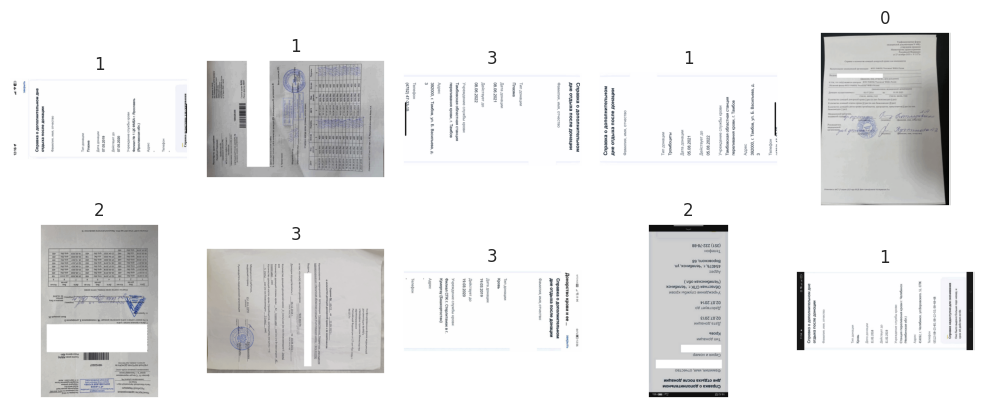

In [ ]:
show_images(PATH_IMAGES, df, 15)

__Вывод:__

В нашем распорядении всего 692 изображения. Данные сбалансированные, состоят из 4 классов.


## Эмбеддинги

### Получим эмбеддинги

In [ ]:
# Конвейер для препроцессинга изображений
preproc = transforms.Compose([
                              transforms.Resize(IMG_SIDE_RESIZE),
                              transforms.CenterCrop(IMG_SIDE_CROP),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD),
                             ])

<div class="alert alert-warning">
<b>такой ресайз исказит пропорции картинок и текста, что может испортить обучение ⚡:</b> </div>
    



In [ ]:
# Модель для векторизации изображений
model_image_vector = resnet50(weights=ResNet50_Weights.DEFAULT)             # предобученная модель resnet50

for param in model_image_vector.parameters():                               # 'заморозка' весов
    param.requires_grad_(False)

layers = list(model_image_vector.children())[:-1]                           # удаление [последнего] слоя для классификации
model_image_vector = nn.Sequential(*layers)                                 # создание модели без слоя для классификации

model_image_vector.eval();

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


In [ ]:
# Функция для векторизации изображений
def get_image_vector(row, path_image):
    img = Image.open(f'{path_image}/{row.image}').convert('RGB') if row.image.endswith('.png') else None
    image_tensor = preproc(img)
    output_tensor = model_image_vector(image_tensor.unsqueeze(0)).flatten()
    return output_tensor.numpy()

In [ ]:
tqdm.pandas()
# Создание массива эмбеддингов
#image_vector = df.apply(get_image_vector, path_image=PATH_IMAGES, axis=1)
#image_vector_array = np.vstack(image_vector)

Для удобства сохраним полученные эмбеддинги, что бы не извлекать их каждый раз.

In [ ]:
# переведем numpy массив полученных эмбеддингов в датафрей
#emb_data = pd.DataFrame(data=image_vector_array)
#emb_data.to_csv('emb_data.csv', header=True, index=False)

In [9]:
# открываем массив эмбеддингов
emb_data = pd.read_csv(EMB)

In [10]:
# сделаем копию датасета
temp_emb_data = emb_data.copy()

In [11]:
## Посмотрим на веторое представление трех изображений
print(emb_data.sample(3))

       0        1         2    3         4    5    6         7        8  \
665  0.0  0.03685  0.002733  0.0  0.011890  0.0  0.0  0.011311  0.00000   
653  0.0  0.01363  0.038059  0.0  0.015871  0.0  0.0  0.000000  0.00000   
497  0.0  0.00000  0.024556  0.0  0.000000  0.0  0.0  0.000000  0.05326   

            9  ...      2038  2039      2040  2041      2042      2043  2044  \
665  0.000000  ...  0.000000   0.0  0.051422   0.0  0.000000  0.010840   0.0   
653  0.000000  ...  0.000698   0.0  0.117132   0.0  0.000000  0.071163   0.0   
497  0.011244  ...  0.000000   0.0  0.000000   0.0  0.005647  0.149387   0.0   

         2045  2046  2047  
665  0.000000   0.0   0.0  
653  0.000000   0.0   0.0  
497  0.001335   0.0   0.0  

[3 rows x 2048 columns]


### Первичный анализ

In [12]:
# функция для первичного анализа
def info(data):
    display(data.info())
    display(data.sample(10))
    display(data.describe().T)
    print(data.isna().sum())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество признаков: ', data.shape[1], 'Количество значений: ', data.shape[0])

In [13]:
info(emb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Columns: 2048 entries, 0 to 2047
dtypes: float64(2048)
memory usage: 10.8 MB


None

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
274,0.000000,0.000000,0.000000,0.0,0.011959,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.009929,0.000000,0.127354,0.000000,0.000000,0.000000,0.0,0.000000
139,0.000000,0.000000,0.002227,0.0,0.000000,0.000000,0.004303,0.000000,0.001394,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003282,0.079395,0.000000,0.000000,0.0,0.000000
483,0.000000,0.000000,0.069926,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.017232,0.012558,0.000000,0.007362,0.000000,0.000000,0.037425,0.0,0.000000
196,0.000000,0.182446,0.011298,0.0,0.099646,0.000000,0.004884,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007612,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
476,0.000000,0.019481,0.000000,0.0,0.248818,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,0.000044,0.031594,0.044409,0.0,0.000000,0.000000,0.000000,0.027928,0.000000,0.000000,...,0.000000,0.000000,0.022077,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
642,0.061288,0.048547,0.092413,0.0,0.003997,0.019766,0.000000,0.000000,0.005875,0.001428,...,0.003124,0.028930,0.003567,0.015262,0.037341,0.036399,0.021754,0.000000,0.0,0.013214
660,0.019406,0.000000,0.016701,0.0,0.019586,0.002170,0.000000,0.000000,0.158840,0.000000,...,0.091554,0.000000,0.000000,0.000000,0.000000,0.129381,0.000000,0.000000,0.0,0.000000
221,0.000000,0.000000,0.000000,0.0,0.019178,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
258,0.000000,0.280893,0.024144,0.0,0.108111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.160207,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


,count,mean,std,min,25%,50%,75%,max
0,692.0,0.016396,0.047761,0.0,0.0,0.000000,0.000182,0.553407
1,692.0,0.052175,0.103219,0.0,0.0,0.001604,0.045427,0.690937
2,692.0,0.031506,0.068404,0.0,0.0,0.011345,0.041056,1.136083
3,692.0,0.000392,0.003607,0.0,0.0,0.000000,0.000000,0.055044
4,692.0,0.046896,0.089405,0.0,0.0,0.000133,0.055256,0.614124
...,...,...,...,...,...,...,...,...
2043,692.0,0.013474,0.040766,0.0,0.0,0.000000,0.002509,0.455345
2044,692.0,0.001746,0.015510,0.0,0.0,0.000000,0.000000,0.300918
2045,692.0,0.003517,0.022191,0.0,0.0,0.000000,0.000000,0.390302
2046,692.0,0.000470,0.004014,0.0,0.0,0.000000,0.000000,0.061504


0       0
1       0
2       0
3       0
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Length: 2048, dtype: int64
Количество дубликатов:  0
Количество признаков:  2048 Количество значений:  692


__Вывод:__
Каждому изображению соответствует свое векторное описание. Дубликаты и пропуска отсутствуют.

## Baseline

### Подготовим данные

In [19]:
# разделим выбоку
features = emb_data
target = df['target']

In [20]:
# разделим выборку на тренировочную и тестовую
X_train, X_val, y_train, y_val = train_test_split(features,\
                                                  target,
                                                    random_state=SEED,
                                                    stratify=target,
                                                    test_size=0.25)

In [21]:
# сделаем копию датасетов
temp_X_train = X_train.copy()
temp_y_train = y_train.copy()
temp_X_val = X_val.copy()
temp_y_val = y_val.copy()

In [22]:
# посмотрим размер датасетов
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(519, 2048)
(519,)
(173, 2048)
(173,)


### LogisticRegression

In [ ]:
%%time
def objective(trial):
    # Список гиперпараметров для перебора
    param = {
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'C': trial.suggest_float('C', 0.001, 0.01),
        'max_iter': trial.suggest_int('max_iter', 500, 1000)
    }

    # Определяю модель машинного обучения, которой передаются гиперпараметры
    estimator = LogisticRegression(**param,
                                   class_weight='balanced',
                                   n_jobs=-1,
                                   random_state=SEED)

    estimator.fit(X_train, y_train)

    # Вычисляем f1_weighted

    return cross_val_score(estimator, X_train, y_train, cv=3, scoring='f1_weighted').mean()

# Подбираем гиперпараметров
sampler = TPESampler(consider_prior=True, multivariate=True, group=True)
optuna_logreg = optuna.create_study(study_name='LogReg', direction='maximize', sampler=sampler)
# Запускаем процесс подбора гиперпараметров
optuna_logreg.optimize(objective, n_trials=5, n_jobs=-1, show_progress_bar=True)

[I 2024-10-01 11:08:17,276] A new study created in memory with name: LogReg


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-10-01 11:08:22,178] Trial 1 finished with value: 0.6226137193805662 and parameters: {'solver': 'sag', 'C': 0.002014823629452478, 'max_iter': 662}. Best is trial 1 with value: 0.6226137193805662.
[I 2024-10-01 11:08:29,816] Trial 2 finished with value: 0.7250552379726741 and parameters: {'solver': 'lbfgs', 'C': 0.009186615036544422, 'max_iter': 575}. Best is trial 2 with value: 0.7250552379726741.
[I 2024-10-01 11:08:30,380] Trial 3 finished with value: 0.5796038236470912 and parameters: {'solver': 'liblinear', 'C': 0.0013220011419210389, 'max_iter': 979}. Best is trial 2 with value: 0.7250552379726741.
[I 2024-10-01 11:08:38,794] Trial 0 finished with value: 0.6796580664763291 and parameters: {'solver': 'saga', 'C': 0.004083593185765185, 'max_iter': 885}. Best is trial 2 with value: 0.7250552379726741.
[I 2024-10-01 11:08:49,425] Trial 4 finished with value: 0.7048599215836183 and parameters: {'solver': 'saga', 'C': 0.005398545753347579, 'max_iter': 648}. Best is trial 2 with v

In [ ]:
# запишем метрику f1
f1_weighted_logreg = round(optuna_logreg.best_value, 2)
best_params_lr = optuna_logreg.best_params
# лучшая метрика и параметры
print('F1_weighted: ', round(optuna_logreg.best_value, 2))
print('best_params: ', optuna_logreg.best_params)

F1_weighted:  0.73
best_params:  {'solver': 'lbfgs', 'C': 0.009186615036544422, 'max_iter': 575}


In [ ]:
# LogisticRegression с лучшими перематры
best_model = LogisticRegression(**best_params_lr,
                                   class_weight='balanced',
                                   n_jobs=-1,
                                   random_state=SEED)

In [ ]:
best_model.fit(X_train, y_train)

LogisticRegression(C=0.009186615036544422, class_weight='balanced',
                   max_iter=575, n_jobs=-1, random_state=42)

In [ ]:
predictions = best_model.predict(X_val)

In [ ]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67        43
           1       0.73      0.70      0.71        43
           2       0.73      0.80      0.76        44
           3       0.66      0.67      0.67        43

    accuracy                           0.71       173
   macro avg       0.70      0.70      0.70       173
weighted avg       0.71      0.71      0.70       173



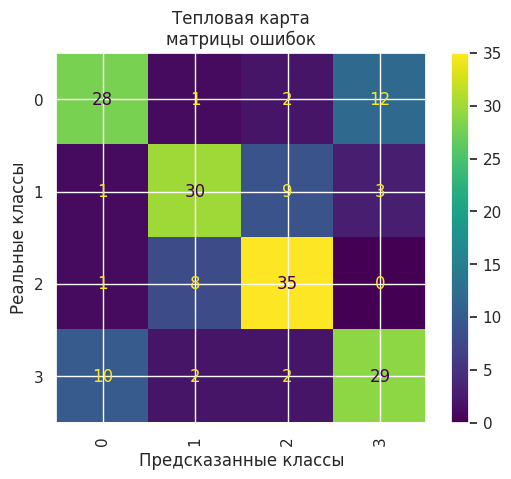

In [ ]:
# названия жанров
labels = ['0', '1', '2', '3']

# матрица ошибок


disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions), display_labels=labels)

disp.plot()
plt.title('Тепловая карта\nматрицы ошибок')
plt.xticks(rotation='vertical')
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')
plt.show()

__Вывод:__

 - С помощью модели Logistic Regression удалосль добиться метрики F_1_weighted = 0.70

 - Самый спорный класс для алгоритма — 0. Алгоритм часто относит изображения класса 0 к классу 4 и, наоборот.

 - Алгоритм распознаёт достаточно хорош изображения класса 2 (35 из 44).

 - accuracy = 0.71. Это значит, что в 71% модель правильно определила ориентацию текста.

### Сatboost

In [24]:
%%time
def objective(trial):
    # Список гиперпараметров для перебора
    param = {
        'depth': trial.suggest_int('depth', 1, 12),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'border_count': trial.suggest_int('border_count', 5, 20),
        'thread_count': trial.suggest_int('thread_count', 3, 4),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 9, 10),
        'random_strength': trial.suggest_float('random_strength', 0.01, 1),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 3)
    }

    # Определяю модель машинного обучения, которой передаются гиперпараметры
    estimator = CatBoostClassifier(**param, verbose=False, loss_function='MultiClass')


    # Вычисляем f1_weighted
    return cross_val_score(estimator, X_train, y_train, cv=3, scoring='f1_weighted').mean()

# Подбираем гиперпараметров
sampler = TPESampler(consider_prior=True, multivariate=True, group=True)
optuna_cbc = optuna.create_study(study_name='CBC', direction="maximize", sampler=sampler)
# Запускаем процесс подбора гиперпараметров
optuna_cbc.optimize(objective, n_trials=5, n_jobs=-1, show_progress_bar=True)

[I 2024-10-06 20:07:28,174] A new study created in memory with name: CBC


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-10-06 20:08:04,857] Trial 0 finished with value: 0.7514839355186315 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.10415846536369493, 'l2_leaf_reg': 3, 'iterations': 316, 'border_count': 11, 'thread_count': 3, 'early_stopping_rounds': 9, 'random_strength': 0.8029851096964912, 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.7514839355186315.
[I 2024-10-06 20:17:35,760] Trial 1 finished with value: 0.754948376131155 and parameters: {'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.16914372877636683, 'l2_leaf_reg': 5, 'iterations': 376, 'border_count': 13, 'thread_count': 4, 'early_stopping_rounds': 9, 'random_strength': 0.5191839671364818, 'max_ctr_complexity': 2}. Best is trial 1 with value: 0.754948376131155.
[I 2024-10-06 20:20:03,012] Trial 2 finished with value: 0.7265580196054594 and parameters: {'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learni

In [25]:
# запишем метрику f1
f1_weighted_cbc = round(optuna_cbc.best_value, 2)
best_params_cbc = optuna_cbc.best_params
# лучшая метрика и параметры
print('F1_weighted: ', round(optuna_cbc.best_value, 2))
print('best_params: ', optuna_cbc.best_params)

F1_weighted:  0.75
best_params:  {'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.16914372877636683, 'l2_leaf_reg': 5, 'iterations': 376, 'border_count': 13, 'thread_count': 4, 'early_stopping_rounds': 9, 'random_strength': 0.5191839671364818, 'max_ctr_complexity': 2}


In [26]:
# LogisticRegression с лучшими перематры
best_model = CatBoostClassifier(**best_params_cbc,
                                   verbose=False, loss_function='MultiClass')

In [27]:
best_model.fit(X_train, y_train)

In [28]:
predictions = best_model.predict(X_val)

In [29]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58        43
           1       0.73      0.77      0.75        43
           2       0.73      0.82      0.77        44
           3       0.59      0.63      0.61        43

    accuracy                           0.68       173
   macro avg       0.68      0.68      0.68       173
weighted avg       0.68      0.68      0.68       173



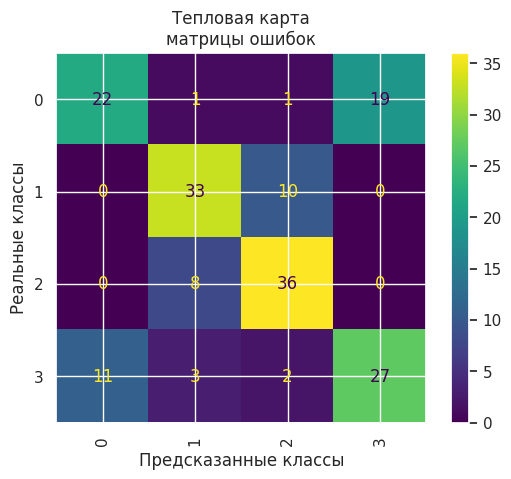

In [30]:
# названия жанров
labels = ['0', '1', '2', '3']

# матрица ошибок


disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions), display_labels=labels)

disp.plot()
plt.title('Тепловая карта\nматрицы ошибок')
plt.xticks(rotation='vertical')
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')
plt.show()

__Вывод:__

 - С помощью модели CatBoostClassifier  удалосль добиться метрики F_1_weighted = 0.68

 - Самый спорный класс для алгоритма — 0. Алгоритм часто относит изображения класса 0 к классу 4 и, наоборот.

 - Алгоритм путается чаще всего классы 0/4 и 2/3.

 - accuracy = 0.68. Это значит, что в 68% модель правильно определила ориентацию текста.

## Fast AI

In [ ]:
# создадим загрузчик данных из папки
dls = ImageDataLoaders.from_folder(path=PATH_IMAGES, valid_pct=0.2, bs=64, item_tfms = Resize(244),
    batch_tfms=[*aug_transforms(size=(244,244)),
                Normalize.from_stats(*imagenet_stats)])
dls.valid_ds.items[:3]

[Path('/content/drive/MyDrive/donor_search/data/3/444___f3cf423723d8492087be404e3b3b338e.png'),
 Path('/content/drive/MyDrive/donor_search/data/3/405___a98cdd5fdc8945f983aab3a33fb86bad.png'),
 Path('/content/drive/MyDrive/donor_search/data/2/405___a2ab612fdf874641abb4b34014b60158.png')]

In [ ]:
# создадим обучкение модели
learn = vision_learner(dls,\
                       models.resnet50, pretrained=True,
                       weights='IMAGENET1K_V2',
                       lr=0.001,
                       metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')],
                       loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=0.0008317637839354575)

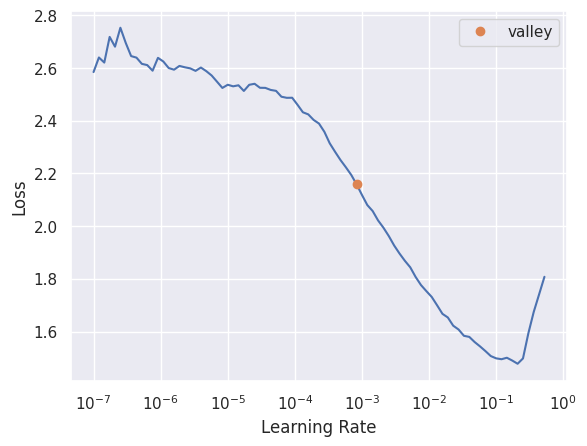

In [ ]:
learn.lr_find() # посмотрим на область 'долины'

Будем использовать скорость обучения модели равную 0.001.

In [ ]:
# запустим обучение на 10 эпохах
learn.fine_tune(100, 1e-3, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=20))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.174579,1.392505,0.318841,0.408480,0.318841,0.314149,00:41


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.244278,1.057032,0.478261,0.502949,0.478261,0.420751,00:24
1,1.194659,0.846661,0.586957,0.656605,0.586957,0.541747,00:26
2,1.149889,0.820665,0.601449,0.646606,0.601449,0.584308,00:26
3,1.113846,0.780246,0.673913,0.710740,0.673913,0.666242,00:24
4,1.034318,0.822149,0.666667,0.698024,0.666667,0.659441,00:25
5,0.994588,0.913424,0.644928,0.672340,0.644928,0.639880,00:26
6,0.951217,0.830458,0.637681,0.655604,0.637681,0.636499,00:24
7,0.902162,0.745853,0.702899,0.711731,0.702899,0.703532,00:26
8,0.861268,0.686575,0.710145,0.720235,0.710145,0.710131,00:24
9,0.824794,0.690737,0.724638,0.735812,0.724638,0.724332,00:26


No improvement since epoch 51: early stopping


In [ ]:
learn.export('my_resnet50_export.pkl') # сохраним обученую модель

In [ ]:
learn.save('xresnet50_save', with_opt=False) # сохраним веса модели

Path('/content/drive/MyDrive/donor_search/data/models/xresnet50_save.pth')

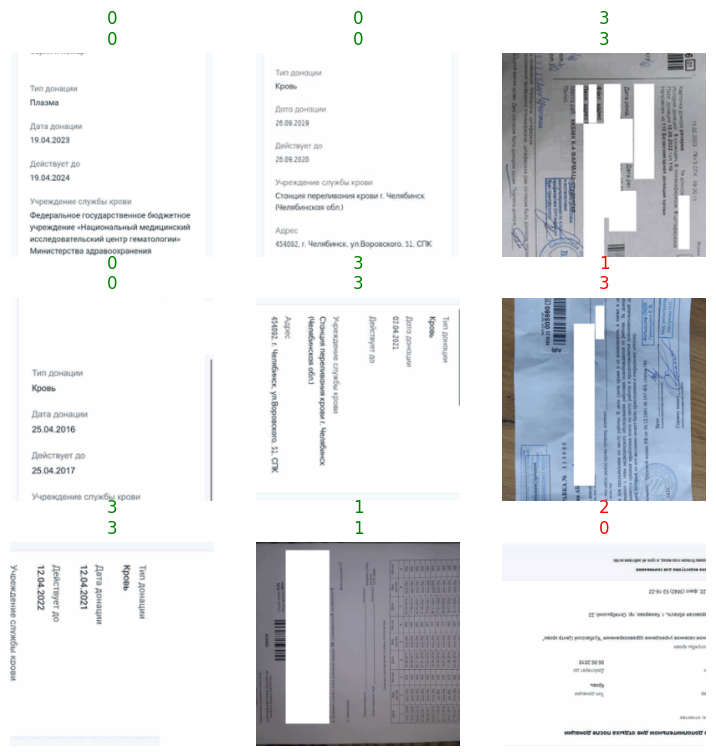

In [ ]:
# посмотрим на каких обложках ошибается или нет наша модель
learn.show_results()

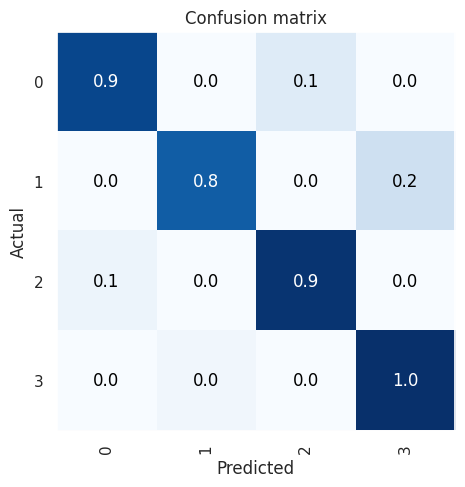

In [ ]:
# матрица ошибок по жанрам
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, norm_dec=1)

__Вывод:__

1) Использую модель ResNet50 на 100 эпохах удалось добиться следующих метрик: accuracy=0.92, precision_score=0.93, recall_score=0.92, f1_score=0.92.

2) Модель все еще путает парные изображения 0/180 градусов и 90/270. Стоит попробовать дообуччить модель на большем наборе данных.

## Проверим работу модели

In [ ]:
# Загрузка модели
learn = load_learner(MY_RESNET50)

In [ ]:
def predict_orientation(image_path):

    '''
    Функция для определения ориентации изобраджения.
    На вход принимает путь к изображения. На выходе получаем предсказанный класс
    '''

    img = PILImage.create(image_path)
    pred, _, _ = learn.predict(img)
    return int(pred)

def rotate_and_save(image_path, output_path):

    '''
    Функция для автоматического поворота изображения.
    На вход принимает путь к исходному изображению и путь к перевернутому изображению.
    На выходе сохраняет перевернутое изобраденние по указанному пути.
    '''

    # Определение ориентации с помощью вашей модели
    orientation = predict_orientation(image_path)

    # Загрузка изображения
    image = Image.open(image_path)

    # Поворот изображения в зависимости от ориентации
    if orientation == 1:
        rotated_image = image.rotate(-90, expand=True)
    elif orientation == 2:
        rotated_image = image.rotate(-180, expand=True)
    elif orientation == 3:
        rotated_image = image.rotate(-270, expand=True)
    else:
        rotated_image = image  # Если ориентация уже 0, оставляем как есть

    # Сохранение повернутого изображения
    rotated_image.save(output_path)
    print(f"Изображение сохранено с ориентацией 0 градусов: {output_path}")

In [ ]:
rotate_and_save(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH) # применим неашу модель

Изображение сохранено с ориентацией 0 градусов: /content/drive/MyDrive/donor_search/pred_image/IMG_3599_pred.png


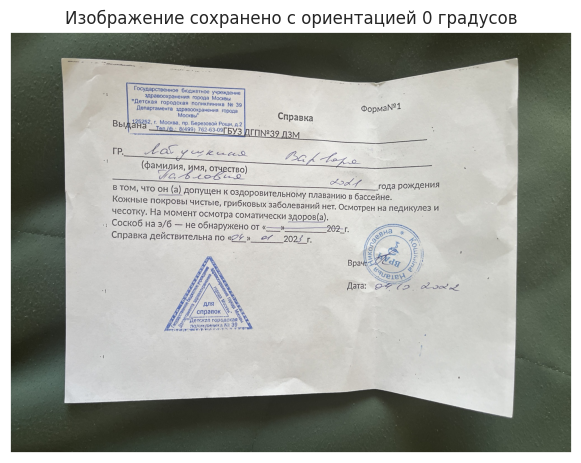

In [ ]:
# посмотрим на результат
image = Image.open(OUTPUT_IMAGE_PATH)
plt.imshow(image)
plt.title('Изображение сохранено с ориентацией 0 градусов')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

__Вывод:__
Модель справилась хорошо, перевернула изображение в нужное положение.

__Общий вывод:__

1) В ходе разработать модель, определения ориентации текста, были изучены 692 справки. Всего предстояла задача разделить имеющиеся справки на 4 класса (0, 90, 180 и 270 градусов).

2) Были обучены две модели классического ML: LogisticRegression и CatBoostClassifier. CatBoostClassifier показал метрику f1_weighted = 0.68, LogisticRegression f1_weighted=0.70. 

3) Используя нейросетевую предобученную модель ResNet50 на 100 эпохах удалось добиться следующих метрик: accuracy=0.92, precision_score=0.93, recall_score=0.92, f1_score=0.92.

4) Анализ модели на тестовых данных показал, что чаще всего она ошибается в парных изображдениях, которые являются зеркалом друг дргуа, а именно: 0/180 градусов и 90/270 градусов.

5) Можно порекомендовать для улучшении метрики дообучить модель на большем количестве данных. Для устойчивости решения стоит разнообразить выборку изображениями с различными рукописными и печатными текстами. Использовать разное освещение, качество и степерь мятости справок.